# Project Overview


Enron Corporation was one of the largest energy, commodities, and services company in USA. By the end of 2001, the company filed for bankruptcy after one of the largest financial scandals in corporate history. In the resulting Federal investigation by the Federal Energy Regulatory Commission, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives -now known as the Enron Corpus-.<br>
The data was then uploaded and made available online, and since then, many organizations and data users were working to clean and organize the data to make it exploitable by public.<br>
In this project, I will use gained skills on the machine learning module to determine with a certain degree of confidence, whom are likely to be a Person Of Interest (POI) based on emails and financial data released and prepared for the public. <br>
A POI is any individual who reach a settlement, plea deal with the government or testified in exchange for prosecution immunity.


In [583]:
import sys
import pickle
sys.path.append("/tools/")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from time import time
from sklearn.grid_search import GridSearchCV
from IPython.display import display
import warnings


### Task 1: Select and categorize the features manually 
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi" (explained in feature_format.py).

target_label = 'poi'

financial_features = ['salary', 'deferral_payments', 'total_payments',
                      'exercised_stock_options', 'bonus', 'restricted_stock',
                      'restricted_stock_deferred', 'total_stock_value', 'expenses',
                      'loan_advances', 'other', 'director_fees', 
                      'deferred_income', 'long_term_incentive']

email_features = ['to_messages', 'email_address','shared_receipt_with_poi', 'from_messages',
                  'from_this_person_to_poi', 'from_poi_to_this_person' ]
              
              
features_list = [target_label] + financial_features + email_features 


### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
df = pd.DataFrame.from_dict(data_dict, orient='index')
df = df.replace('NaN', np.nan)



# Explore the data set

We will strat exploring the data set that we are working with:


In [584]:
df.shape

(146, 21)

In [585]:
len(features_list)

21

Our data set has 146 row and 21 column, so we have 146 person and 21 feature to explore.

In [586]:
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,NaN,2195.0,152.0,65.0,False,NaN,-3081055.0,304805.0,phillip.allen@enron.com,47.0
BADUM JAMES P,NaN,NaN,178980.0,182466.0,257817.0,NaN,NaN,NaN,NaN,257817.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477.0,566.0,NaN,916197.0,4046157.0,NaN,1757552.0,465.0,-560222.0,5243487.0,...,NaN,29.0,864523.0,0.0,False,NaN,-5104.0,NaN,james.bannantine@enron.com,39.0
BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,NaN,NaN,10623258.0,...,NaN,NaN,2660303.0,NaN,False,NaN,-1386055.0,1586055.0,NaN,NaN
BAY FRANKLIN R,239671.0,NaN,260455.0,827696.0,NaN,400000.0,145796.0,NaN,-82782.0,63014.0,...,NaN,NaN,69.0,NaN,False,NaN,-201641.0,NaN,frank.bay@enron.com,NaN


In [587]:
df[df['poi']==1]['poi'].count()

18

Base on the data set there are only 18 POIs, whereas there are 35 POI's in the text file that was hand generated. 

In [588]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       95 non-null float64
to_messages                  86 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
bonus                        82 non-null float64
restricted_stock             110 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
loan_advances                4 non-null float64
from_messages                86 non-null float64
other                        93 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          146 non-null bool
director_fees                17 non-null float64
deferred_income              49 non-null float

# Data Cleaning

Lets check if there are NaN's on the data set, if so, I'll replace the NaN's on the financial features by 0 and the email features by the median of the column.

In [589]:
# cheking the total number of NaN's value in the data set :

print("The total of NaN values in the dataset: {}".format(df.isnull().sum().sum()))


The total of NaN values in the dataset: 1358


In [590]:
# replacing NaN's by 0 for financial features :

df = df.replace('NaN', np.nan)
df[financial_features] = df[financial_features].fillna(0)

# replacing NaN's by 0 for email  features :

df[email_features] = df[email_features].fillna(df[email_features].median())

In [591]:
# cheking if the NaN's value have been replaced:

df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,0.0,2195.0,152.0,65.0,False,0.0,-3081055.0,304805.0,phillip.allen@enron.com,47.0
BADUM JAMES P,0.0,1211.0,178980.0,182466.0,257817.0,0.0,0.0,740.5,0.0,257817.0,...,0.0,41.0,0.0,8.0,False,0.0,0.0,0.0,NaN,35.0
BANNANTINE JAMES M,477.0,566.0,0.0,916197.0,4046157.0,0.0,1757552.0,465.0,-560222.0,5243487.0,...,0.0,29.0,864523.0,0.0,False,0.0,-5104.0,0.0,james.bannantine@enron.com,39.0
BAXTER JOHN C,267102.0,1211.0,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,740.5,0.0,10623258.0,...,0.0,41.0,2660303.0,8.0,False,0.0,-1386055.0,1586055.0,NaN,35.0
BAY FRANKLIN R,239671.0,1211.0,260455.0,827696.0,0.0,400000.0,145796.0,740.5,-82782.0,63014.0,...,0.0,41.0,69.0,8.0,False,0.0,-201641.0,0.0,frank.bay@enron.com,35.0


As we see, the NaN's are replaced either by 0 for financial features or by the median of the column for the email features.

Since, the email feature as it is a non quantitative feature and has no added value to our analysis. It will be removed from the features list

In [592]:
#features_list.remove ('email_address')

In [593]:
#df.drop(columns=['email_address'])

In [594]:
len(features_list)
print(features_list)

['poi', 'salary', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'other', 'director_fees', 'deferred_income', 'long_term_incentive', 'to_messages', 'email_address', 'shared_receipt_with_poi', 'from_messages', 'from_this_person_to_poi', 'from_poi_to_this_person']


In [595]:
# cheking if the NaN's value have been replaced:

df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,0.0,2195.0,152.0,65.0,False,0.0,-3081055.0,304805.0,phillip.allen@enron.com,47.0
BADUM JAMES P,0.0,1211.0,178980.0,182466.0,257817.0,0.0,0.0,740.5,0.0,257817.0,...,0.0,41.0,0.0,8.0,False,0.0,0.0,0.0,NaN,35.0
BANNANTINE JAMES M,477.0,566.0,0.0,916197.0,4046157.0,0.0,1757552.0,465.0,-560222.0,5243487.0,...,0.0,29.0,864523.0,0.0,False,0.0,-5104.0,0.0,james.bannantine@enron.com,39.0
BAXTER JOHN C,267102.0,1211.0,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,740.5,0.0,10623258.0,...,0.0,41.0,2660303.0,8.0,False,0.0,-1386055.0,1586055.0,NaN,35.0
BAY FRANKLIN R,239671.0,1211.0,260455.0,827696.0,0.0,400000.0,145796.0,740.5,-82782.0,63014.0,...,0.0,41.0,69.0,8.0,False,0.0,-201641.0,0.0,frank.bay@enron.com,35.0


In [596]:
print("The total of NaN values in the dataset: {}".format(df.isnull().sum().sum()))


The total of NaN values in the dataset: 35


# Outliers

I'll check if there is any outlier by exploring the most important features in the financial data "Salary" and "bonus".

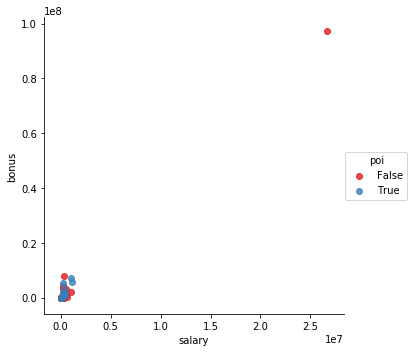

In [597]:
sns.lmplot('salary', 'bonus', 
           data=df, 
           fit_reg=False,
           palette="Set1",
           hue='poi')
plt.show()

There is an obvious outlier in the plot above that need to be investegated. 

In [598]:
#Investigating the non-POI entity with the unreasonable salary value
df['salary'].idxmax()

'TOTAL'

So the above outlier is actually the sum of the salaries and since this is not an individual key it will be manually removed. 


In [599]:
# removing the total outlier
df.drop(axis=0, labels = 'TOTAL', inplace=True)



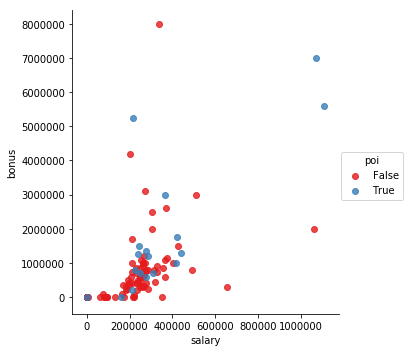

In [600]:
sns.lmplot('salary', 'bonus', 
           data=df, 
           fit_reg=False,
           palette="Set1",
           hue='poi')
plt.show()

After removing the total outlier, it seems like we have some more outliers. In fact those values will not be considered as outliers rather they will be considered as evidence against POI's due to exorbitant  



# Creating new features


By assuming that a potential POI may have significant number of sent/received emails with another POI. 

It's worthwhile looking into the emails variables. The assumption is that people who received/sent a significant amount of emails from/to POI might also have been a POI. Hence, a closer look at the number of emails being sent/received could be helpful in identifying POIs.

Two new features will be created and added to the features list to help us identify a potential POI:
- From POI 
- To POI


In [601]:
# Create the new email features
df_newf = df.copy()
df_newf['to_poi_ratio'] = df['from_poi_to_this_person'] / df['to_messages']
df_newf['from_poi_ratio'] = df['from_this_person_to_poi'] / df['from_messages']

# Add new email features to the features list
features_list.append('to_poi_ratio')
features_list.append('from_poi_ratio')


In [602]:
len(features_list)

23

In [603]:


print(features_list)

['poi', 'salary', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'other', 'director_fees', 'deferred_income', 'long_term_incentive', 'to_messages', 'email_address', 'shared_receipt_with_poi', 'from_messages', 'from_this_person_to_poi', 'from_poi_to_this_person', 'to_poi_ratio', 'from_poi_ratio']


# Scale features


Since I'm not using algorithms that used distance metrics or linear regressionin this project it is not necessary to perform scaling on the features. Scaling feature is sweetable for distance metrics and linear regression.
 

# Feature reduction

 
Since our data is relatively small, I'll use StratifiedShuffleSplit returns stratified randomized folds to split data into training and testing data set, and I'll use "SelectPercentile" from sklearn to select the  X% of the most powerful features to do my analysis. <br>
Before reducing the number of feature to minimize the dimension of the dataframe. The email feature as it is a non quantitative feature and has no added value to our analysis. It will be removed from the features list


In [604]:
data = df.drop(['poi', 'email_address'], axis=1)
X = data.values
y = df.poi

In [605]:
features_list.remove ('email_address')

In [606]:
print (features_list)

['poi', 'salary', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'other', 'director_fees', 'deferred_income', 'long_term_incentive', 'to_messages', 'shared_receipt_with_poi', 'from_messages', 'from_this_person_to_poi', 'from_poi_to_this_person', 'to_poi_ratio', 'from_poi_ratio']


In [607]:
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)

StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train_reduce10 = SelectPercentile(percentile=10).fit_transform(X_train, y_train)
    X_test_reduce10 = SelectPercentile(percentile=10).fit_transform(X_test, y_test)
    
    X_train_reduce30 = SelectPercentile(percentile=30).fit_transform(X_train, y_train)
    X_test_reduce30 = SelectPercentile(percentile=30).fit_transform(X_test, y_test)
    
    X_train_reduce50 = SelectPercentile(percentile=50).fit_transform(X_train, y_train)
    X_test_reduce50 = SelectPercentile(percentile=50).fit_transform(X_test, y_test)
    
    X_train_reduce70 = SelectPercentile(percentile=70).fit_transform(X_train, y_train)
    X_test_reduce70 = SelectPercentile(percentile=70).fit_transform(X_test, y_test)

In [608]:
def rate_models(X,y):
    models = {"AdaBoost Classifier": AdaBoostClassifier(), "Gaussian Naive Bayes": GaussianNB(), 
                  "Decision Tree Classifier": tree.DecisionTreeClassifier(), "Random Forest Classifier": RandomForestClassifier()} 


    data = {"": X_train, "(10% of features)": X_train_reduce10, "(30% of features)": X_train_reduce30,
                         "(50% of features)": X_train_reduce50, "(70% of features)": X_train_reduce70,}

    res = {}

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        for name, model in models.items():
            for scale, X in data.items():
                n = name + " " + scale
                clf = model
                accuracy = cross_val_score(clf, X_train, y_train).mean()

                y_pred = cross_val_predict(clf, X_train, y_train)

                rec = cross_val_score(clf, X_train, y_train, scoring=make_scorer(recall_score)).mean()
                prec = cross_val_score(clf, X_train, y_train, scoring=make_scorer(recall_score)).mean()
                f1 = cross_val_score(clf, X_train, y_train, scoring=make_scorer(recall_score)).mean()


                res[n] = {"MeanAccuracy": accuracy, "Precision": prec, "Recall": rec, "F1Score": f1}

    results = pd.DataFrame.from_dict(res, orient="index")
    results = results[["MeanAccuracy", "Precision", "Recall", "F1Score"]]

    display(results)

In [609]:
rate_models(X,y)

,MeanAccuracy,Precision,Recall,F1Score
AdaBoost Classifier,0.779444,0.222222,0.222222,0.222222
AdaBoost Classifier (10% of features),0.779444,0.222222,0.222222,0.222222
AdaBoost Classifier (30% of features),0.779444,0.222222,0.222222,0.222222
AdaBoost Classifier (50% of features),0.779444,0.222222,0.222222,0.222222
AdaBoost Classifier (70% of features),0.779444,0.222222,0.222222,0.222222
Decision Tree Classifier,0.848889,0.444444,0.666667,0.444444
Decision Tree Classifier (10% of features),0.848889,0.666667,0.444444,0.555556
Decision Tree Classifier (30% of features),0.835000,0.666667,0.444444,0.666667
Decision Tree Classifier (50% of features),0.848889,0.666667,0.444444,0.444444
Decision Tree Classifier (70% of features),0.835000,0.444444,0.444444,0.666667


# Testing


The first training and testing will be done on all of the initial features in the dataset. This is in order to gauge the importance of the features and to serve a baseline to observe the performance before any feature selection or parameter tuning.

Four algorithms are selected for the testing : (AdaBoost, Naive Bayes, Decision tree classifier and Random Forest). For each algorithm, evaluation metrics including accuracy, precision, recall and f1 score will be calculated for a varying number of features from SelectPercentile and PCA methods.

Precision, recall and f1 score are used as metrics to evaluate the model performance.

>Precision measures how many of the items labeled as positive truely belong to the positive class. Precision will show out of the cases that are identified as POIs how many are actually POIs. 

$$ precision = \frac{true\ positives}{true\ positives + false\ positives} $$

>Recall measure out of all the items that are truely positive, how many were correctly classified as positive. Recall will show out of the cases that are actually POIs how many were identified as POIs.

\\[ recall = \frac{true\ positives}{true\ positives + false\ negatives} \\]

Precision is also known as positive predictive value while recall is called the sensitivity of the classifier. 

>F1 score is the harmonic mean of precision and recall. F1 formula is defiend as : 

\\[ F1\ Score = \frac{2\ (precision\ x\ recall)}{precision + recall} \\]


In [610]:
def rate_models(X,y):
    models = {"AdaBoost Classifier": AdaBoostClassifier(), "Gaussian Naive Bayes": GaussianNB(), 
                  "Decision Tree Classifier": tree.DecisionTreeClassifier(), "Random Forest Classifier": RandomForestClassifier()} 


    data = {"": X_train}

    res = {}

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        for name, model in models.items():
            for scale, X in data.items():
                n = name + " " + scale
                clf = model
                accuracy = cross_val_score(clf, X_train, y_train).mean()

                y_pred = cross_val_predict(clf, X_train, y_train)

                rec = cross_val_score(clf, X_train, y_train, scoring=make_scorer(recall_score)).mean()
                prec = cross_val_score(clf, X_train, y_train, scoring=make_scorer(recall_score)).mean()
                f1 = cross_val_score(clf, X_train, y_train, scoring=make_scorer(recall_score)).mean()


                res[n] = {"MeanAccuracy": accuracy, "Precision": prec, "Recall": rec, "F1Score": f1}

    results = pd.DataFrame.from_dict(res, orient="index")
    results = results[["MeanAccuracy", "Precision", "Recall", "F1Score"]]

    display(results)

In [611]:
rate_models(X,y)

,MeanAccuracy,Precision,Recall,F1Score
AdaBoost Classifier,0.779444,0.222222,0.222222,0.222222
Decision Tree Classifier,0.835000,0.666667,0.444444,0.666667
Gaussian Naive Bayes,0.421667,0.777778,0.777778,0.777778
Random Forest Classifier,0.835556,0.000000,0.111111,0.000000


The next training and testing will be done on the new dataset that include the new feautres.

In [612]:
data = df_newf.drop(['poi', 'email_address'], axis=1)
X = data.values
y = df.poi

In [613]:
labels, features = targetFeatureSplit(data)
# Training and testing data set :
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)

StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    

In [614]:
rate_models(X,y)

,MeanAccuracy,Precision,Recall,F1Score
AdaBoost Classifier,0.835000,0.444444,0.444444,0.444444
Decision Tree Classifier,0.862778,0.555556,0.444444,0.666667
Gaussian Naive Bayes,0.421667,0.777778,0.777778,0.777778
Random Forest Classifier,0.862778,0.000000,0.111111,0.111111


To summerize the results of the testing, the table Below is showing the scores for Precision- Recall and F1 score for both data set ( with and without new features):



|Classifier|New featres used |Precision | Recall  |F1 score  |
| ------------- |:-------------:|:-------------:| -----:|-----:|
| Adaboost     | No | 0.22 |0.22  | 0.22 |
| Adaboost     | Yes | 0.44 | 0.44 | 0.44  |
| Decision Tree |No | 0.667 | 0.44  | 0.667 |  
| Decision Tree | Yes | 0.667|  0.44  | 0.556  |
| Naive Bayes | No |0.778 | 0.778  | 0.778  |
| Naive Bayes | Yes | 0.778 | 0.778  | 0.778  |
| Random Forest | No |  0.11  | 0.11 | 0.33 |
| Random Forest | Yes | 0.22 | 0 | 0.22 |


The top performing algorithms are : Naive Bayes and Decision tree, and as we see the new features had no effect on the naive bayes and decision tree. However the precision and the recall for adaboost was increased by 100%.

# Tuning

Parameter tuning is the process of optimizing the "settings" of a machine learning algorithm to achieve maximum performance on a given dataset. And because our number 1 performer, GaussianNB, doesn't actually have any parameters to tune. I choose to tune the parameters of Decision tree classifier using the initial data set because this classifier has the second best F1 score.

We will be tuning:

- The minimum number of samples required to be at a leaf node
- The maximum depth of the tree

The proces of parameter tuning for a dataset can either by carried out manually by selecting or combaining different scenarios or it can be automated by another algorithm such as GridSearch. GridSearch is an approach to parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid.
Since my classifier performance is F1 score, I will tune my algoritm parameter using the min_samples_leaf, max_depth, and criterion. 


In [615]:
parameters = {
    'criterion': ('gini', 'entropy'),
    'min_samples_leaf':range(1, 50, 5),
    'max_depth': range(1, 10)
}

scorer = make_scorer(f1_score)

DTC = DecisionTreeClassifier(random_state=42)

clf = GridSearchCV(DTC, param_grid=parameters, scoring=scorer)

clf.fit(X_train_pca5, y_train)

clf.best_params_, clf.best_score_ 

C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135:

C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135:

C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135:

C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135:

C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135:

C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135:

C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hamajid\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135:

({'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 6},
 0.5469667318982387)

# Evaluation and Validation  

Validation is a process used to evaluate the trained model with a testing dataset. The goal of it is to test the generalization ability of a trained model. Cross validation is a way of measuring the predictive performance of a model. A classic mistake while performing cross validation is overfitting the data. when this occurs a model is trained very well on a set of data but is then not able to make correct predictions in the testing set.

We'll split the data set in to a training and testing set. Using StratifiedShuffleSplit returns stratified randomized folds. Since the data set we are dealing with is relatively small and unbalanced, using StratifiedShuffleSplit to randomly split the dataset, and use the whole dataset for both buidling and assessing the model should lead to a more stable evaluation.

Let's predict some POI from test data set. 

In [616]:
clf = DecisionTreeClassifier(splitter="random",
                             max_depth=4,
                             criterion='entropy',
                             min_samples_split=10,
                             max_leaf_nodes=6,
                             class_weight="balanced",
                             random_state=42)

clf.fit(X_train_pca5,y_train)


DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=4, max_features=None, max_leaf_nodes=6,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='random')

In [617]:
clf = GaussianNB()
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

accuracy = accuracy_score(pred,y_test)

### try Naive Bayes for prediction

print "Accuracy =", accuracy
print 'Recall = ', recall_score(y_test,pred)

print 'Precision = ', precision_score(y_test,pred)

Accuracy = 0.3055555555555556
Recall =  0.4444444444444444
Precision =  0.08163265306122448


In [618]:
clf = GaussianNB()
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

pred = pd.Series(pred, index=[y_test.index], name='Predicted')

predictions = pd.concat([y_test, pred])

predictions[:10]

HIRKO JOSEPH          True
KISHKILL JOSEPH G    False
KITCHEN LOUISE       False
KOENIG MARK E         True
KOPPER MICHAEL J      True
LAVORATO JOHN J      False
LAY KENNETH L         True
LEFF DANIEL P        False
LEMAISTRE CHARLES    False
LEWIS RICHARD        False
dtype: bool

# Conclusion

By running the tester.py our results meet the minimum required for the project, but is not good enough to determine if a person should be prosecuted as POI  :

Accuracy: 76%
Precision: 31%
Recall: 66%
F1 score: 42%
